<a href="https://colab.research.google.com/github/boothmanrylan/historicalFiresQC/blob/main/historicalFiresQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone Repo and Load Modules

In [1]:
import tensorflow as tf
import os
from google.colab import drive
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
drive.mount('/content/drive/')
%cd /content/drive/My\ Drive/historicalFiresQC

# if the directory doesn't exist clone it from github
! if [ ! -d ./historicalFiresQC/ ]; then git clone https://github.com/boothmanrylan/historicalFiresQC.git; fi


%cd ./historicalFiresQC/
! git pull
%cd ../

! pip install q -r ./historicalFiresQC/requirements.txt

# import modules from historicalFiresQC
from historicalFiresQC import model as Model
from historicalFiresQC import data as Data
from historicalFiresQC import assessment as Assessment
from historicalFiresQC import visualize as Visualize

Mounted at /content/drive/
/content/drive/My Drive/historicalFiresQC
/content/drive/My Drive/historicalFiresQC/historicalFiresQC
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/boothmanrylan/historicalFiresQC
   4a98cce..ac2c886  refdata    -> origin/refdata
Updating 4a98cce..ac2c886
Fast-forward
 historicalFiresQC.ipynb | 388 ++++++++++++++++++++++++++++++++++++------------
 1 file changed, 297 insertions(+), 91 deletions(-)
Already on 'refdata'
Your branch is up to date with 'origin/refdata'.
/content/drive/My Drive/historicalFiresQC
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-sawcw2p4
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-sawcw2p4
  Created wheel for tensorflow-examples: filename=tensorflow_examples

# Reload Modules

This is only necessary to run if changes have been made to the historicalFiresQC modules since you started using the colab notebook. It will pull the changes and reload the modules, allowing the changes to be incorporated without having to restart the runtime. 

In [34]:
%cd ./historicalFiresQC
! git pull
%cd ../

from importlib import reload

Model = reload(Model)
Data = reload(Data)
Assessment = reload(Assessment)
Visualize = reload(Assessment)

/content/drive/My Drive/historicalFiresQC/historicalFiresQC
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (delta 4), reused 6 (delta 4), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/boothmanrylan/historicalFiresQC
   03c9be3..85185db  refdata    -> origin/refdata
Updating 03c9be3..85185db
Fast-forward
 assessment.py | 8 +++++++-
 1 file changed, 7 insertions(+), 1 deletion(-)
/content/drive/My Drive/historicalFiresQC


# Global Variables

In [37]:

PATH = '/content/drive/My Drive/historicalFiresQC/'
DATAPATH = PATH + 'Data/Reference Annotations/'
MODELPATH = PATH + 'Models/CleanAnnotations/'
SHAPE = (128, 128, 4)
CLASSES = 6
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCHS = 10
STEPS_PER_EPOCH = 10

# setting this to true will load the model/weights from MODELPATH
LOADMODEL = True

# setting this to false will skip the model training step, therefore
# only set to false if LOADMODEL is true
TRAINMODEL = False

# if LOADMODEL and TRAINMODEL are both true, the model/weights saved at
# MODELPATH will be overwritten after the model is retrained


# dataset options
train_pattern = DATAPATH + 'train*.tfrecord.gz'
val_pattern = DATAPATH + 'val*.tfrecord.gz'
test_pattern = DATAPATH + 'test*.tfrecord.gz'
clean_annotation = False
noisy_annotation = False
combined_burnt = False
split_burnt = False
get_ref_points = True
get_merged_ref_points = False
get_burn_age = False
get_merged_burn_age = False

# Load Data

In [3]:
print('Getting Training Data...')
train_dataset = Data.get_dataset(
    train_pattern, SHAPE[:-1], batch_size=BATCH_SIZE, filters=Data.filter_no_burnt,
    shuffle=True, repeat=True, prefetch=True, clean_annotation=clean_annotation,
    noisy_annotation=noisy_annotation, combined_burnt=combined_burnt,
    split_burnt=split_burnt, get_ref_points=get_ref_points,
    get_merged_ref_points=get_merged_ref_points, get_burn_age=get_burn_age,
    get_merged_burn_age=get_merged_burn_age
)
print('Done Getting Training Data.\n')

print('Getting Validation Data...')
val_dataset = Data.get_dataset(
    val_pattern, SHAPE[:-1], batch_size=BATCH_SIZE, filters=None,
    shuffle=False, repeat=False, prefetch=True, clean_annotation=clean_annotation,
    noisy_annotation=noisy_annotation, combined_burnt=combined_burnt,
    split_burnt=split_burnt, get_ref_points=get_ref_points,
    get_merged_ref_points=get_merged_ref_points, get_burn_age=get_burn_age,
    get_merged_burn_age=get_merged_burn_age
)
print('Done Getting Validation Data.\n')

print('Getting Test Data...')
test_dataset = Data.get_dataset(
    test_pattern, SHAPE[:-1], batch_size=1, filters=None,
    shuffle=False, repeat=False, prefetch=True, clean_annotation=clean_annotation,
    noisy_annotation=noisy_annotation, combined_burnt=combined_burnt,
    split_burnt=split_burnt, get_ref_points=get_ref_points,
    get_merged_ref_points=get_merged_ref_points, get_burn_age=get_burn_age,
    get_merged_burn_age=get_merged_burn_age
)
print('Done Getting Test Data.\n')


Getting Training Data...
Done Getting Training Data.

Getting Validation Data...
Done Getting Validation Data.

Getting Test Data...
Done Getting Test Data.



# Build Model

In [38]:
print('Building Model...')
model = Model.build_unet_model(input_shape=SHAPE, classes=CLASSES)
if LOADMODEL:
    if os.path.exists(MODELPATH + 'saved_model.pb'): # load the entire model
        model = tf.keras.models.load_model(MODELPATH)
    else: # just load the model weights
        model.load_weights(MODELPATH)
print('Done Building Model.\n')

if TRAINMODEL:
    checkpoint = tf.keras.callbacks.ModelCheckPoint(
        filepath=MODELPATH, save_weights_only=True,
        save_freq=10 * STEPS_PER_EPOCH
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics=['accuracy']
    
    print('Compiling Model...')
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print('Done Compiling Model.\n')
    
    print('Training Model...')
    model.fit(
        train_dataset, epochs=EPOCHS, verbose=1,
        steps_per_epoch=STEPS_PER_EPOCH, callback=[checkpoint]
    )
    print('Done Traing Model.\n')

Building Model...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/applications/imagenet_utils.py:333: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


Done Building Model.



<!-- # Model Assessment -->

# Assessment

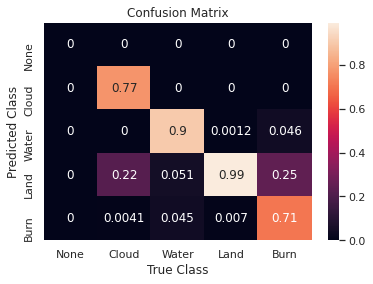

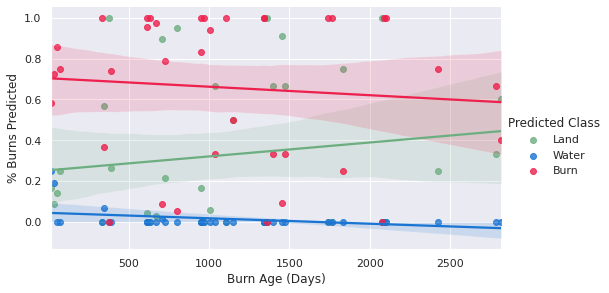

In [39]:
def assessment(model, datasetpattern, merged_refs, class_labels):
    reference_dataset = Data.get_dataset(
        datasetpattern, SHAPE[:-1], shuffle=False, repeat=False,
        clean_annotation=False, noisy_annotation=False, combined_burnt=False,
        split_burnt=False, get_ref_points=(not merged_refs),
        get_merged_ref_points=merged_refs, get_burn_age=False,
        get_merged_burn_age=False
    )

    burn_age_dataset = Data.get_dataset(
        datasetpattern, SHAPE[:-1], shuffle=False, repeat=False,
        clean_annotation=False, noisy_annotation=False, combined_burnt=False,
        split_burnt=False, get_ref_points=False, get_merged_ref_points=False,
        get_burn_age=(not merged_refs), get_merged_burn_age=merged_refs
    )

    num_classes = len(class_labels)

    confusion_matrix = Assessment.reference_accuracy(
        model, reference_dataset, num_classes
    )

    norm_confusion_matrix = Assessment.normalize_confusion_matrix(
        confusion_matrix
    )

    Assessment.plot_confusion_matrix(
        norm_confusion_matrix, class_labels
    )
    
    Assessment.plot_burn_accuracy_by_burn_age(
        model, burn_age_dataset, class_labels
    )


class_labels = ['None', 'Cloud', 'Water', 'Land', 'Burn']
assessment(model, [val_pattern, test_pattern], False, class_labels)